#Getting Started..

In this notebook we shall be dealing with Machine Hack Dataset, consisting columns named ID, Price, Levy, Manufacturer, Model, Prod. Year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags each representing various features of the vehicle.

It is divided into two sets 'Train.csv' and 'Test.csv' with 19237 and 8245 entries respectively for training the model and predicting the 'Price' column in test dataset.

##Importing Libraries and Datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Reading the data
train_data = pd.read_csv(r'/content/drive/MyDrive/AI ML DL/Machine Hack/train.csv')
test_data = pd.read_csv(r'/content/drive/MyDrive/AI ML DL/Machine Hack/test.csv')
y_data=train_data['Price']
train_data=train_data.drop('ID', axis=1)
test_data=test_data.drop('ID', axis=1)
data=pd.concat([train_data.drop('Price', axis=1), test_data.drop('Price', axis=1)], axis=0)

train_data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


#Data Pre-Processing

In this section, we will be cleaning the dataset and extracting the useful features from the dataset to feed our model.

In [ ]:
#Pre-Preocesing the Columns manually
data['Mileage']=data['Mileage'].apply(lambda x: int(x[:-3]))
data['Age']=data['Prod. year'].apply(lambda x: 2021-x if x>0 else x)
data['Levy']=data['Levy'].apply(lambda x: 0 if x=='-' else int(x))
data['Turbo']=data['Engine volume'].apply(lambda x: 'yes' if 'turbo' in x.lower() else 'no')
data['Engine volume']=data['Engine volume'].apply(lambda x: float(x.split(' ')[0]) if 'turbo' in x.lower() else float(x))
data['Doors']=data['Doors'].apply(lambda x: 2 if '02-Mar' in x else (4 if '04-May' in x else 6))
data=data.drop(['Prod. year'], axis=1)
data.dtypes

Levy                  int64
Manufacturer         object
Model                object
Category             object
Leather interior     object
Fuel type            object
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                 int64
Wheel                object
Color                object
Airbags               int64
Age                   int64
Turbo                object
dtype: object

In [ ]:
num_columns=['Levy','Engine volume','Mileage','Cylinders','Doors','Airbags','Age']
cat_columns=['Model','Manufacturer','Category','Leather interior','Fuel type','Gear box type','Drive wheels','Wheel','Color','Turbo']

le=LabelEncoder()
data[cat_columns]=data[cat_columns].apply(le.fit_transform)
data.head()

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Age,Turbo
0,1399,33,1547,4,1,2,3.5,186005,6.0,0,0,4,0,12,12,11,0
1,1018,8,816,4,0,5,3.0,192000,6.0,2,0,4,0,1,8,10,0
2,0,22,849,3,0,5,1.3,200000,4.0,3,1,4,1,1,2,15,0
3,862,16,819,4,1,2,2.5,168966,4.0,0,0,4,0,14,0,10,0
4,446,22,849,3,1,5,1.3,91901,4.0,0,1,4,0,12,4,7,0


In [ ]:
norm = StandardScaler()
y = np.log(y_data)
data['Levy'] = norm.fit_transform(np.array(data['Levy']).reshape(-1,1))
data['Manufacturer'] = norm.fit_transform(np.array(data['Manufacturer']).reshape(-1,1))
data['Model'] = norm.fit_transform(np.array(data['Model']).reshape(-1,1))
data['Mileage'] = norm.fit_transform(np.array(data['Mileage']).reshape(-1,1))
data['Color'] = norm.fit_transform(np.array(data['Color']).reshape(-1,1))
data['Age'] = norm.fit_transform(np.array(data['Age']).reshape(-1,1))
data['Cylinders'] = norm.fit_transform(np.array(data['Cylinders']).reshape(-1,1))
data.head()

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Age,Turbo
0,1.349417,-0.078922,0.929142,4,1,2,3.5,-0.026593,0.994606,0,0,4,0,0.790596,12,0.161990,0
1,0.675441,-1.413256,-0.500498,4,0,5,3.0,-0.026468,0.994606,2,0,4,0,-1.259927,8,-0.015543,0
2,-1.125367,-0.666029,-0.435959,3,0,5,1.3,-0.026302,-0.419929,3,1,4,1,-1.259927,2,0.872121,0
3,0.399482,-0.986269,-0.494631,4,1,2,2.5,-0.026946,-0.419929,0,0,4,0,1.163418,0,-0.015543,0
4,-0.336408,-0.666029,-0.435959,3,1,5,1.3,-0.028544,-0.419929,0,1,4,0,0.790596,4,-0.548141,0


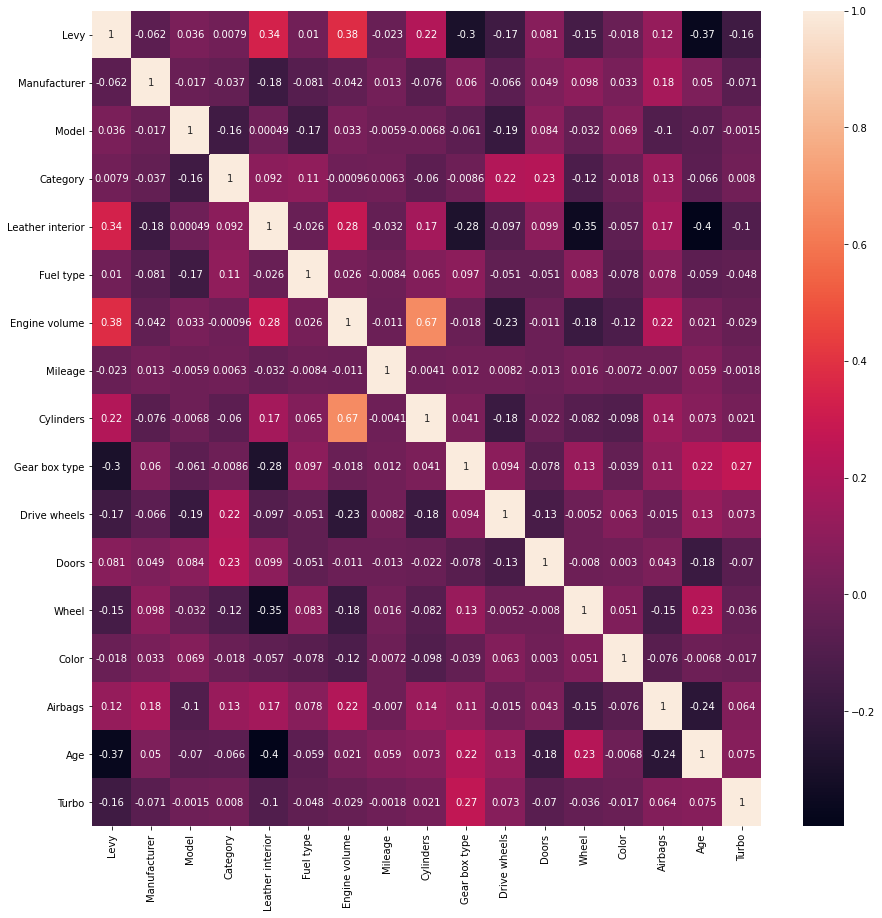

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True)
plt.show()

In [ ]:
# Function to calculate VIF
def calculate_vif(data):
   vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
   x_var_names = data.columns
   for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
   return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

#calculate_vif(data)
#calculate_vif(test_data.drop('Price',axis=1))


In [ ]:
#omit=['Doors']
#f=data.drop(omit, axis=1)
#test_data=test_data.drop(omit, axis=1)
#calculate_vif(f)

#Model Building

In this section we'll build and train various machine learning models to make predictions and tune them.

In [ ]:
# Manually seperating dataset into training, validating and Prediction sets
x=data.iloc[:19237,:]
x_tr,x_val,y_tr,y_val=train_test_split(x,y,test_size=0.2,random_state=0)
x_test=data.iloc[19237:,:]

In [ ]:
models=[LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), SVR(), BaggingRegressor(), AdaBoostRegressor()]

for i in range(0,8):
  model= models[i]
  model.fit(x_tr,y_tr)
  y_pred=model.predict(x_val)
  score=r2_score(y_val,y_pred)
  data={'Model': str(models[i]), 'Accuracy': score*100}
  if i==0:
    Accuracy=pd.DataFrame(data, index=[1])
  else:
    Accuracy=Accuracy.append(data, ignore_index=True)

In [ ]:
Accuracy

,Model,Accuracy
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14.162227
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",-0.005115
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14.161934
3,"RandomForestRegressor(bootstrap=True, ccp_alph...",65.100118
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",36.456091
5,"KNeighborsRegressor(algorithm='auto', leaf_siz...",53.461433
6,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",35.774144
7,"BaggingRegressor(base_estimator=None, bootstra...",60.769847


In [ ]:
br=BaggingRegressor()
br.fit(x_tr,y_tr)
y_pred_1=br.predict(x_val)
print('r2_score={}'.format(r2_score(y_val, y_pred_1)))
print('RMSLE={}'.format(np.sqrt(mean_squared_log_error(y_val, y_pred_1))))

r2_score=0.6277584103567915
RMSLE=0.12895816144121194


In [ ]:

def get_mea(max_leaf_nodes,min_samples_split, x_tr, y_tr, x_val, y_val):
  model=RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split, random_state=0)
  model.fit(x_tr,y_tr)
  y_pred=model.predict(x_val)
  mae = mean_absolute_error(y_val, y_pred)
  return mae

for i in [7980,7990,8000]:
  for j in [5,6,7]:
    mae=get_mea(i,j, x_tr, y_tr, x_val, y_val)
    print('Max_nodes {} , min_nodes {}  mae {}'.format(i,j,mae))

Max_nodes 7980 , min_nodes 5  mae 0.4852199526649588
Max_nodes 7980 , min_nodes 6  mae 0.4887294378708006
Max_nodes 7980 , min_nodes 7  mae 0.4923063375269272
Max_nodes 7990 , min_nodes 5  mae 0.4852199526649588
Max_nodes 7990 , min_nodes 6  mae 0.4887294378708006
Max_nodes 7990 , min_nodes 7  mae 0.4923063375269272
Max_nodes 8000 , min_nodes 5  mae 0.4852199526649588
Max_nodes 8000 , min_nodes 6  mae 0.4887294378708006
Max_nodes 8000 , min_nodes 7  mae 0.4923063375269272


In [ ]:
rf=RandomForestRegressor(n_estimators=5000, min_samples_split=6, max_leaf_nodes=7990, n_jobs=-1)
rf.fit(x_tr,y_tr)
y_pred_2=rf.predict(x_val)
print(r2_score(y_val,y_pred_2))
print(np.sqrt(mean_squared_log_error(y_val, y_pred_2)))

0.6554068288924346
0.12597078446533697


In [ ]:
xgb=XGBRegressor(n_estimators=10000, learning_rate=0.05, n_jobs=-1)
xgb.fit(x_tr, y_tr, early_stopping_rounds=20, eval_set=[(x_val, y_val)], verbose=False)
y_pred_3=xgb.predict(x_val)
print('r2_score={}'.format(r2_score(y_val, y_pred_3)))
print('RMSLE={}'.format(np.sqrt(mean_squared_log_error(y_val, y_pred_3))))

[07:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r2_score=0.5622643298926788
RMSLE=0.1403538564830944


Let's try buliding an ANN and caluclute the rmsle error.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, Callback

loss_function='mean_absolute_error'

price_predictor=Sequential()

price_predictor.add(Dense(1000,activation='relu', input_dim=17))  
price_predictor.add(Dense(800))
price_predictor.add(Dense(700,activation='relu'))
price_predictor.add(Dense(500))
price_predictor.add(Dense(200))
price_predictor.add(Dense(50))
price_predictor.add(Dense(1))
price_predictor.summary()

price_predictor.compile(optimizer='Adam', loss=loss_function)

price_predictor.fit(x_tr, y_tr, epochs=20, batch_size=500, verbose=0)
y_pred_4=price_predictor.predict(x_val)
score=r2_score(y_val,y_pred_4)
print(score)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              18000     
_________________________________________________________________
dense_1 (Dense)              (None, 800)               800800    
_________________________________________________________________
dense_2 (Dense)              (None, 700)               560700    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

From the above results we can conclude that Random Forest model gives the least rmsle error when compared to other models. Therefore we use it to predict the prices in test dataset.

In [ ]:
results=rf.predict(x_test)
prices=pd.DataFrame(np.exp(results), columns=['Price'])
prices.to_csv("Submission.csv",index=False)